# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including [LlamaIndex](https://www.llamaindex.ai/) and [LangChain](https://www.langchain.com/), however, the goal of building from scratch is to be able to inspect and customize all the parts.

## What is RAG?

RAG stands for Retrieval Augmented Generation.

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

Two primary improvements can be seen as:
1. **Preventing "hallucinations"** - LLMs are incredible but they are prone to potential hallucination, as in, generating something that *looks* correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data. 


## What kind of problems can RAG be used for?

RAG can help anywhere there is a specific set of information that an LLM may not have in its training data (e.g. anything not publicly accessible on the internet).

For example you could use RAG for:
* **Customer support Q&A chat** - By treating your existing customer support documentation as a resource, when a customer asks a question, you could have a system retrieve relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation". Klarna, a large financial company, [uses a system like this](https://www.klarna.com/international/press/klarna-ai-assistant-handles-two-thirds-of-customer-service-chats-in-its-first-month/) to save $40M per year on customer support costs.
* **Email chain analysis** - Let's say you're an insurance company with long threads of emails between customers and insurance agents. Instead of searching through each individual email, you could retrieve relevant passages and have an LLM create strucutred outputs of insurance claims.
* **Company internal documentation chat** - If you've worked at a large company, you know how hard it can be to get an answer sometimes. Why not let a RAG system index your company information and have an LLM answer questions you may have? The benefit of RAG is that you will have references to resources to learn more if the LLM answer doesn't suffice.
* **Textbook Q&A** - Let's say you're studying for your exams and constantly flicking through a large textbook looking for answers to your quesitons. RAG can help provide answers as well as references to learn more. (we will try to implement this)

All of these have the common theme of retrieving relevant resources and then presenting them in an understandable way using an LLM.

From this angle, you can consider an LLM a calculator for words.


## Why local?

Privacy, speed, cost.

Running locally means you use your own hardware.

From a privacy standpoint, this means you don't have send potentially sensitive data to an API.

From a speed standpoint, it means you won't necessarily have to wait for an API queue or downtime, if your hardware is running, the pipeline can run.

And from a cost standpoint, running on your own hardware often has a heavier starting cost but little to no costs after that.

Performance wise, LLM APIs may still perform better than an open-source model running locally on general tasks but there are more and more examples appearing of smaller, focused models outperforming larger models. 

## Key terms

| Term | Description |
| ----- | ----- | 
| **Token** | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word, part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM. |
| **Embedding** | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values. |
| **Embedding model** | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 tokens of text and turn it into a vector of size 768. An embedding model can and often is different to an LLM model. |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, two pieces of similar text passed through an embedding model should have a high similarity score, whereas two pieces of text about different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity. |
| **Large Language Model (LLM)** | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!". This generation will be highly dependant on the training data and prompt. |
| **LLM context window** | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items from the retrieval system to aid with its generation. |
| **Prompt** | A common term for describing the input to a generative LLM. The idea of prompt engineering is to structure a text-based (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). | 




 ## What we're going to build

We're going to build RAG pipeline which enables us to chat with a PDF document, specifically an open-source [nutrition textbook](https://pressbooks.oer.hawaii.edu/humannutrition2/), ~1200 pages long.

You could call our project NutriChat!

We'll write the code to:
1. Open a PDF document (you could use almost any PDF here).
2. Format the text of the PDF textbook ready for an embedding model (this process is known as text splitting/chunking).
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.

The above steps can broken down into two major sections:
1. Document preprocessing/embedding creation (steps 1-3).
2. Search and answer (steps 4-6).

And that's the structure we'll follow.

It's similar to the workflow outlined on the NVIDIA blog which [details a local RAG pipeline](https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/).

<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

## Requirements and setup

* Local NVIDIA GPU
* Environment setup 
* Data source (for example, a PDF). 
* Internet connection (to download the models, but once you have them, it'll run offline).

## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document 

This will work with many other kinds of documents.

However, we'll start with PDF since many people have PDFs.

But just keep in mind, text files, email chains, support documentation, articles and more can also work.

We're going to pretend we're nutrition students at the University of Hawai'i, reading through the open-source PDF textbook [*Human Nutrition: 2020 Edition*](https://pressbooks.oer.hawaii.edu/humannutrition2/).

There are several libraries to open PDFs with Python but I found that [PyMuPDF](https://github.com/pymupdf/pymupdf) works quite well in many cases.

First we'll download the PDF if it doesn't exist.

In [41]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [2]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Now let's get a random sample of the pages.

In [3]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 1136,
  'page_char_count': 1841,
  'page_word_count': 311,
  'page_sentence_count_raw': 22,
  'page_token_count': 460.25,
  'text': 'In the United States, there are additional subgroups that are at  risk and are more likely than others to face hunger and malnutrition.  They include low-income families and the working poor, who are  employed but have incomes below the federal poverty level.  Senior citizens are also a major at-risk group. Many elderly people  are frail and isolated, which affects their ability to meet their dietary  requirements. In addition, many also have low incomes, limited  resources, and difficulty purchasing or preparing food due to health  issues or poor mobility. As a result, more than six million senior  citizens in the United States face the threat of hunger.6  One of the groups that struggles with hunger are the millions  of homeless people across North America. According to a recent  study by the US Conference of Mayors, the majority of rep

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the [`sentence-transformers`](https://www.sbert.net/docs/pretrained_models.html) model [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`. 

In [6]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This is another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This is another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [7]:
for item in tqdm(pages_and_texts):
    item["sentences"]=list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': -35,
  'page_char_count': 1037,
  'page_word_count': 191,
  'page_sentence_count_raw': 1,
  'page_token_count': 259.25,
  'text': 'The Cardiovascular System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  82  Central Nervous System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  94  The Respiratory System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  99  The Endocrine System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  106  The Urinary System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  110  The Muscular System  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  117  The Skeletal System  University of Hawai‘i at Mānoa Food Science and 

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [9]:
df=pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we group those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [10]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 191,
  'page_char_count': 1540,
  'page_word_count': 271,
  'page_sentence_count_raw': 14,
  'page_token_count': 385.0,
  'text': 'Other Functions of Chloride  Chloride has several other functions in the body, most importantly  in acid-base balance. Blood pH is maintained in a narrow range and  the number of positively charged substances is equal to the number  of negatively charged substances. Proteins, such as albumin, as well  as bicarbonate ions and chloride ions, are negatively charged and  aid in maintaining blood pH. Hydrochloric acid (a gastric acid  composed of chlorine and hydrogen) aids in digestion and also  prevents the growth of unwanted microbes in the stomach.  Immune-system cells require chloride, and red blood cells use  chloride anions to remove carbon dioxide from the body.  Chloride Imbalances  Low dietary intake of chloride and more often diarrhea can cause  low blood levels of chloride. Symptoms typically are similar to those  of hyponatremia and

In [12]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [13]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [14]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 107,
  'sentence_chunk': 'in the endocrine system are the pituitary, thyroid, parathyroid, adrenals, thymus, pineal, pancreas, ovaries, and testes. The glands secrete hormones, which are biological molecules that regulate cellular processes in other target tissues, so they require transportation by the circulatory system. Adequate nutrition is critical for the functioning of all the glands in the endocrine system. A protein deficiency impairs gonadal-hormone release, preventing reproduction. Athletic teenage girls with very little body fat often do not menstruate. Children who are malnourished usually do not produce enough growth hormone and fail to reach normal height for their age group. Probably the most popularized connection between nutrition and the functions of the endocrine system is that unhealthy dietary patterns are linked to obesity and the development of Type 2 diabetes. The Centers for Disease Control and Prevention (CDC) estimates that twenty-six million

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [16]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 27.5 | Text: Figure 15.1 reused “Silohuette of Three People” by photo- nic.co.uk nic / Unsplash License 1158 | Attributions
Chunk token count: 25.25 | Text: The Polynesian Family System in Ka-‘u. Rutland, Vermont: Charles E. Tuttle Company 780 | Introduction
Chunk token count: 15.5 | Text: https://www.ncbi.nlm.nih.gov/pubmed/24456350 Introduction | 57
Chunk token count: 25.25 | Text: PART XV CHAPTER 15. LIFESPAN NUTRITION IN ADULTHOOD Chapter 15. Lifespan Nutrition in Adulthood | 901
Chunk token count: 17.75 | Text: Table 6.1 Essential and Nonessential Amino Acids Defining Protein | 365


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [17]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

Smaller chunks filtered!

Time to embed our chunks of text!

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.


Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [18]:
from sentence_transformers import SentenceTransformer

embedding_model=SentenceTransformer(model_name_or_path='all-mpnet-base-v2', device='cpu')

#Create a list of Sentences
sentences=["I like football","I like basketball", "Kobe is a great player"]

#Sentences are encoded/embedded by calling model.encode()
embeddings=embedding_model.encode(sentences)
embeddings_dict=dict(zip(sentences, embeddings))

#See embeddings
for sentence, embeddings in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embeddings: {embeddings}")
    print("")



Sentence: I like football
Embeddings: [-8.42475444e-02  1.00637212e-01 -3.04262508e-02 -4.04835865e-03
  3.78771499e-02  3.74091119e-02 -9.98117849e-02  2.61343946e-03
  1.68801006e-02 -1.06646698e-02 -9.36578587e-03 -4.31236029e-02
  7.33321533e-03  1.65348276e-02  1.87982209e-02 -7.59599684e-03
 -2.98678111e-02 -2.66341437e-02  1.27094649e-02 -1.01594571e-02
  8.85396637e-03  4.13204506e-02 -1.35907661e-02 -4.72090393e-02
 -1.78263839e-02  4.68517244e-02 -7.70462630e-03 -4.88640293e-02
 -3.99428159e-02  1.04912810e-01 -1.95646044e-02 -3.23913395e-02
 -5.61739877e-02 -5.53603768e-02  1.33881906e-06  1.68700833e-02
 -7.19039282e-03 -2.36500334e-02  6.86780587e-02  2.94983350e-02
  4.66499925e-02  3.60918837e-03 -4.46939059e-02 -4.21173312e-02
 -1.59445629e-02  4.67798449e-02  3.78085896e-02  2.07526819e-03
 -2.71698646e-02  1.42831588e-02  5.78409992e-03 -4.98900842e-03
 -5.02601489e-02 -1.26381991e-02 -4.07727212e-02  1.14967311e-02
  3.48693170e-02  2.09056195e-02  3.40205804e-02  4.

Woah! That's a lot of numbers.

How about we do just once sentence?

In [19]:
single_sentence = "Who is Michael Jordan?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Who is Michael Jordan?
Embedding:
[ 1.48610771e-03 -1.29408650e-02  4.12214510e-02  1.48524977e-02
  4.33810474e-03  1.77816706e-04  1.77243222e-02 -1.45564685e-02
  3.38754840e-02 -3.48900668e-02  2.58417353e-02  2.15714537e-02
  1.22249816e-02  2.01746691e-02  3.11459322e-02 -1.97694656e-02
  2.88256221e-02 -2.19796542e-02  1.69615056e-02 -6.30995631e-03
 -3.76892760e-02  3.13616637e-03  1.31576005e-02  4.23933007e-02
 -6.79306760e-02 -3.42432857e-02  1.42761124e-02 -1.04357312e-02
 -3.40646617e-02  2.10747235e-02 -5.73627837e-02 -3.49448919e-02
  3.54876113e-03 -5.57608232e-02  1.40041789e-06  8.85181408e-03
  5.87321296e-02 -1.26579041e-02  4.14434522e-02 -3.53717878e-02
 -3.66200916e-02 -4.22541238e-02 -6.18494349e-03  2.17272546e-02
 -1.62388813e-02 -3.43839340e-02  1.98135171e-02 -2.18353979e-02
 -1.34257283e-02  9.53534525e-03  4.17782478e-02 -1.07229194e-02
  3.07925977e-02 -3.29672098e-02 -3.48641463e-02 -1.76475141e-02
  2.64758412e-02  5.72366677e-02 -9.53142047e-

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

How about we add an embedding field to each of our chunk items?

Let's start by trying to create embeddings on the CPU, we'll time it with the `%%time` magic to see how long it takes.

In [20]:
%%time

# the model is on the CPU
embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 11min 18s, sys: 5.84 s, total: 11min 24s
Wall time: 11min 39s


This would take a *really* long time if we had a larger dataset.

In [21]:
%%time

text_chunks=[item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 375 μs, sys: 0 ns, total: 375 μs
Wall time: 380 μs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [22]:
len(text_chunks)

1680

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [23]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [24]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02280062e-02 -5.09550702e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156679e-02 5.92137799e-02 -1.66167784e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801488e-02 3.39813270e-02 -2.06427258e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566613e-02 3.81274521e-02 -8.46859254e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49772710e-03 9.57151968e-...


### Chunking and embedding questions

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

If we've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, we may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.



## 2. RAG - Search and Answer

Let's say we had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How? 

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

Google kind of uses this workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [25]:
import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [26]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242601, 0.0902280062, -0.00509550702, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156679, 0.0592137799, -0.0166167784, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801488, 0.033981327, -0.0206427258, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566613, 0.0381274521, -0.00846859254, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264419, -0.0084977271, 0.00957151968, -..."


In [27]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1676e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1828e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6136e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6370e-02,  3.7492e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4899e-04, -9.9662e-02,  4.9

Nice!

Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above. 

In [28]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:
1. Define a query string (e.g. `"macronutrients functions"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts. 

Easy!

In [29]:
# 1. Define the query
query="macronutrients function"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product


Query: macronutrients function
Time take to get scores on 1680 embeddings: 0.00055 seconds.


torch.return_types.topk(
values=tensor([0.7085, 0.6669, 0.6496, 0.6391, 0.6130]),
indices=tensor([42, 47, 41, 46, 51]))

Woah!! Now that was fast!

~0.00038 seconds to perform a dot product comparison across 1680 embeddings on my machine.

GPUs are optimized for these kinds of operations.

So even if you we're to increase our embeddings by 100x (1680 -> 168,000), an exhaustive dot product operation would happen in ~0.038 seconds (assuming linear scaling).

Heck, let's try it.

In [30]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

We can clearly see the sentence chunk!! Our semantic search has clearly succeeded.

In [31]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.02850 seconds.


Wow. That's quick!

That means we can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as Faiss.

Let's check the results of our original similarity search.

`torch.topk` returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [32]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

*Now* we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [33]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients function'

Results:
Score: 0.7085
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

The first result looks to have nailed it!

We get a very relevant answer to our query `"macronutrients functions"` even though its quite vague.

That's the power of semantic search!

And even better, if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

In [34]:
top_results_dot_product

torch.return_types.topk(
values=tensor([0.7085, 0.6669, 0.6496, 0.6391, 0.6130]),
indices=tensor([42, 47, 41, 46, 51]))

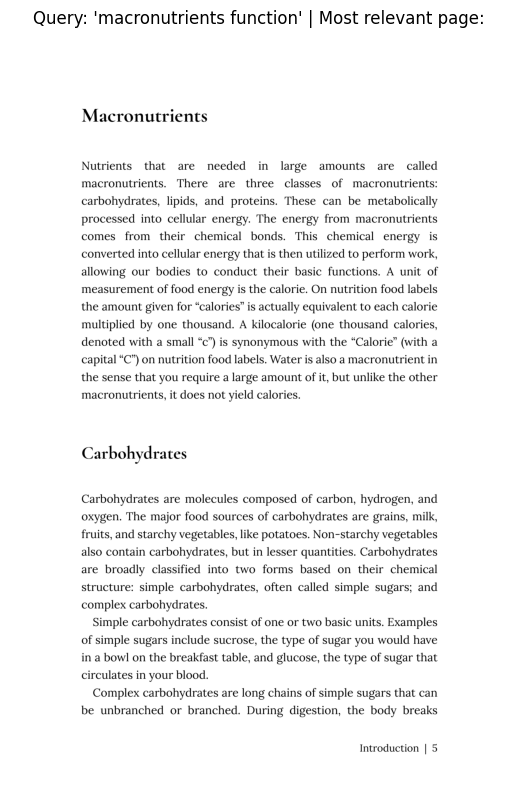

In [35]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
idx = int(pages_and_chunks[top_results_dot_product.indices[0]]['page_number'])
page = doc.load_page(41+idx) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [36]:
top_results_dot_product[0]

tensor([0.7085, 0.6669, 0.6496, 0.6391, 0.6130])

Nice!

Now we can do extra research if we'd like.

We could repeat this workflow for any kind of query we'd like on our textbook.

And it would also work for other datatypes too.

We could use semantic search on customer support documents.

Or email threads.

Or company plans.

Or our old journal entries.

Almost anything!

The workflow is the same:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

And we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

Before we get to the next two steps, let's take a small aside and discuss similarity measures.

### Similarity measures: dot product and cosine similarity 

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude. 

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like CLIP you can measure the similarity between text and image embeddings.

In [37]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1,vector2)

def cosine_similarity(vector1,vector2):
    dot_product=torch.dot(vector1,vector2)
    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them. 

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [38]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")
    pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
    doc = fitz.open(pdf_path)
    idx = int(pages_and_chunks[indices[0]]['page_number'])
    page = doc.load_page(41+idx) # number of page (our doc starts page numbers on page 41)

    # Get the image of the page
    img = page.get_pixmap(dpi=300)

    # Optional: save the image
    #img.save("output_filename.png")
    doc.close()

    # Convert the Pixmap to a numpy array
    img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

    # Display the image using Matplotlib
    plt.figure(figsize=(13, 10))
    plt.imshow(img_array)
    plt.title(f"Query: '{query}' | Most relevant page:")
    plt.axis('off') # Turn off axis
    plt.show()

Excellent! Now let's test our functions out.

In [39]:
query = "foods high in fiber"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00038 seconds.


(tensor([0.6964, 0.6810, 0.5566, 0.5344, 0.5187]),
 tensor([ 418,  360,  358, 1047,  412]))

[INFO] Time taken to get scores on 1680 embeddings: 0.00044 seconds.
Query: foods high in fiber

Results:
Score: 0.6964
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number: 276


Score: 0.6810
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down

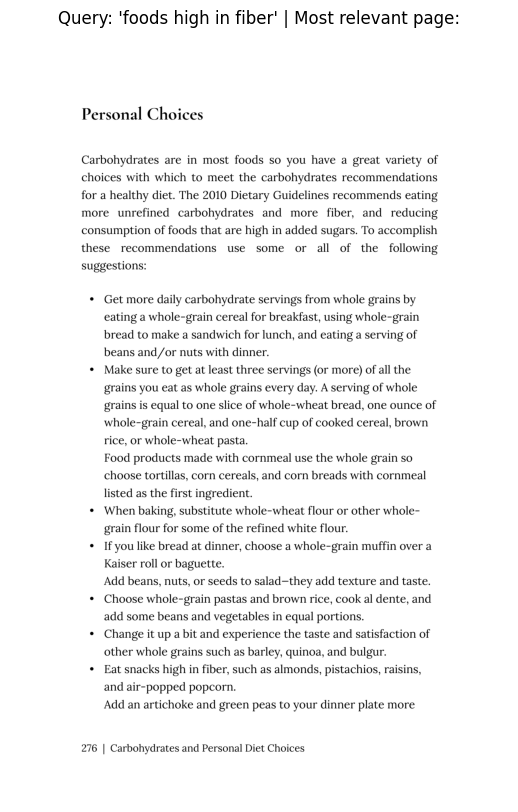

In [40]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

### Semantic search/vector search extensions 

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search in tandem.

Our dataset is small and allows for an exhaustive search (comparing the query to *every* possible result) but if you start to work with large scale datasets with hundred of thousands, millions or even billions of vectors, you'll want to implement an index.

You can think of an index as sorting your embeddings before you search through them.

So it narrows down the search space.

For example, it would be inefficient to search every word in the dictionary to find the word "duck", instead you'd go straight to the letter D, perhaps even straight to the back half of the letter D, find words close to "duck" before finding it.

That's how an index can help search through many examples without comprimising too much on speed or quality.

One of the most popular indexing libraries is Faiss. 

Faiss is open-source and was originally created by Facebook to deal with internet-scale vectors and implements many algorithms such as HNSW (Hierarchical Naviganle Small Worlds).

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally? 
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs. 

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |





> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [5]:
from huggingface_hub import login
login(new_session=False)

In [14]:
from huggingface_hub import snapshot_download

snapshot_download(repo_id="meta-llama/Llama-2-7b-hf", repo_type="model")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

GatedRepoError: 403 Client Error. (Request ID: Root=1-686ac853-7345947009bf89364b4be2a3;df60df24-3c60-441a-b39c-3331be292e4d)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-hf/resolve/01c7f73d771dfac7d292323805ebc428287df4f9/.gitattributes.
Your request to access model meta-llama/Llama-2-7b-hf is awaiting a review from the repo authors.

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-7b-it",
    torch_dtype=torch.bfloat16
)

input_text = "Write me a poem about Machine Learning."
input_ids = tokenizer(input_text, return_tensors="pt")

outputs = model.generate(**input_ids)
print(tokenizer.decode(outputs[0]))


OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
Check your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
model_id = "google/gemma-7b-it"

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-7b-it


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-7b-it.
401 Client Error. (Request ID: Root=1-686ac3b0-469b8c03208f8f464114a9e7;83334a74-1914-4fc4-9459-1d7afea7bca1)

Cannot access gated repo for url https://huggingface.co/google/gemma-7b-it/resolve/main/config.json.
Access to model google/gemma-7b-it is restricted. You must have access to it and be authenticated to access it. Please log in.